torch.Size([1, 3, 240, 320])


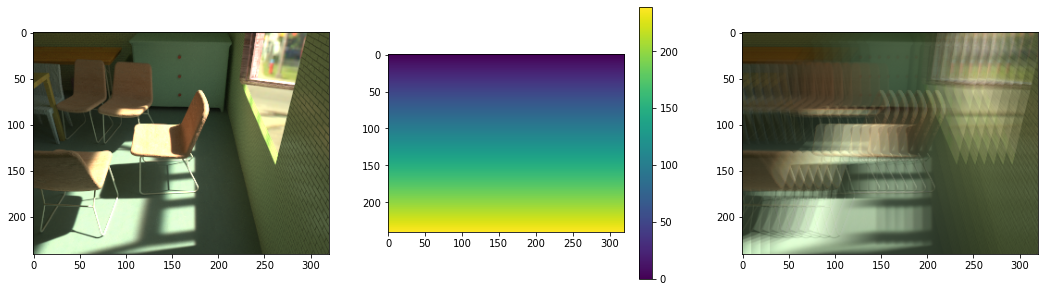

In [1]:
%reload_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import sys
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/train/third-parties/pacnet')
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/third-parties_outside/Deformable-Convolution-V2-PyTorch/functions')
import pac_simplified as pac

import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

im_path = 'test.png'
im_uint8 = imageio.imread(im_path)
im_float = im_uint8.astype(np.float32) / 255.
im_tensor = torch.from_numpy(im_float).float().permute(2, 0, 1).unsqueeze(0).cuda()
# affinity = torch.ones_like(im_tensor).cuda()
# feature = torch.rand_like(im_tensor).cuda()
H, W = im_uint8.shape[:2]
xx, yy = np.meshgrid(list(range(0, W)), list(range(0, H)))
feature = torch.from_numpy(yy).unsqueeze(0).expand(4, -1, -1).cuda().float().unsqueeze(0)
plt.figure(figsize=(18, 5))
plt.subplot(131)
plt.imshow(im_uint8)
plt.subplot(132)
plt.imshow(yy)
plt.colorbar()

acco_pool_mean = pac.PacPool2d(kernel_size=7, stride=1, padding=30, dilation=10, normalize_kernel=True, native_impl=False, \
                              if_deform=False)
im_pooled, kernels = acco_pool_mean(im_tensor, feature)

print(im_pooled.shape)

plt.subplot(133)
plt.imshow(im_pooled.squeeze().detach().cpu().permute(1, 2, 0).numpy())
plt.show()

torch.Size([1, 3, 240, 320]) Time used 0.0011
grad on im_tensor.weight: torch.Size([3, 3, 3, 3]) tensor([[[86328.1484, 86650.0469],
         [92742.2266, 93126.3594]],

        [[86328.1484, 86650.0469],
         [92742.2266, 93126.3594]],

        [[86328.1484, 86650.0469],
         [92742.2266, 93126.3594]]], device='cuda:0') True


/home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
/home/ruizhu/anaconda3/envs/semanticInverse/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for

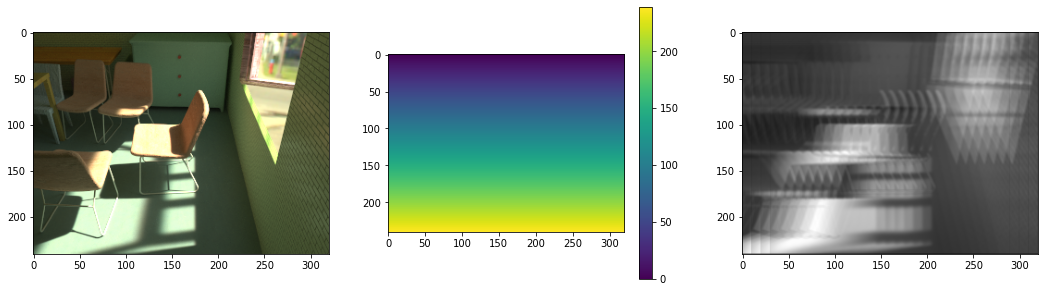

In [14]:
import sys
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/train/third-parties/pacnet')
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/third-parties_outside/Deformable-Convolution-V2-PyTorch/functions')
import pac_simplified as pac
# import pac

import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import time

im_path = 'test.png'
im_uint8 = imageio.imread(im_path)
im_float = im_uint8.astype(np.float32) / 255.
im_tensor = torch.from_numpy(im_float).float().permute(2, 0, 1).unsqueeze(0).cuda()
im_tensor.requires_grad = True
# affinity = torch.ones_like(im_tensor).cuda()
# feature = torch.rand_like(im_tensor).cuda()
im_tensor_op = nn.Conv2d(3, 3,
                        kernel_size=(3, 3),
                        stride=(1, 1),
                        padding=(1, 1), 
                        bias=True).cuda()

im_tensor_op.weight.data.fill_(1.0)
im_tensor_op.bias.data.fill_(0.0)
im_tensor = im_tensor_op(im_tensor)

H, W = im_uint8.shape[:2]
xx, yy = np.meshgrid(list(range(0, W)), list(range(0, H)))
feature = torch.from_numpy(yy).unsqueeze(0).expand(4, -1, -1).cuda().float().unsqueeze(0)

N, inC, inH, inW = im_tensor.shape 
deformable_groups = 1
outC = 3
kH, kW = 7, 7
kernel_size=(kH, kW)
stride = (1, 1)
padding = 30
dilation=10

conv_offset_op = nn.Conv2d(inC, deformable_groups * 2 * kH * kW,
                        kernel_size=(kH, kW),
                        stride=(1, 1),
                        padding=padding,
                        dilation=dilation, 
                        bias=True).cuda()

conv_offset_op.weight.data.fill_(0.0)
conv_offset_op.bias.data.fill_(0.0)
offsets = conv_offset_op(im_tensor)
# offsets = offsets + 50
# offsets = torch.zeros_like(offsets, device=offsets.device, requires_grad=True) + 10
# offsets[:, 1::2, :, :] = offsets[:, 1::2, :, :] + 100

if_deform = False

# acco_pool_mean = pac.PacPool2d(kernel_size=7, stride=1, padding=30, dilation=10, normalize_kernel=True, native_impl=True, \
#                               if_deform=if_deform).cuda()
# acco_pool_mean = pac.PacPool2d(kernel_size=7, stride=1, padding=30, dilation=10, normalize_kernel=True, native_impl=True).cuda()
acco_pool_mean = pac.PacConv2d(in_channels=3, out_channels=3, kernel_size=7, stride=1, padding=30, dilation=10, normalize_kernel=True, \
                               native_impl=False, if_deform=if_deform).cuda()
acco_pool_mean.weight.data.fill_(1.0)
acco_pool_mean.bias.data.fill_(0.0)
time_start = time.time()
im_pooled, kernels = acco_pool_mean(im_tensor, feature, offsets=offsets if if_deform else None)
# im_pooled, kernels = acco_pool_mean(im_tensor, feature)
time_used = time.time() - time_start

print(im_pooled.shape, 'Time used %.4f'%time_used)

loss = torch.sum(im_pooled)
loss.backward()
if offsets.grad is not None:
    print('grad on offsets:', offsets.grad, offsets.requires_grad)
    print('grad on conv_offset_op.weight:', conv_offset_op.weight.grad.shape, conv_offset_op.weight.requires_grad)
# print('grad on im_tensor:', im_tensor.grad[0, :2, :4, 0], im_tensor.requires_grad)
print('grad on im_tensor.weight:', im_tensor_op.weight.grad.shape, im_tensor_op.weight.grad[:, :2, :2, 0], im_tensor_op.weight.requires_grad)

if offsets.grad is not None:
    print(conv_offset_op.weight.grad[:3, :, -1, -1])

plt.figure(figsize=(18, 5))
plt.subplot(131)
plt.imshow(im_uint8)
plt.subplot(132)
plt.imshow(yy)
plt.colorbar()
plt.subplot(133)
im_pooled = im_pooled / torch.max(im_pooled)
plt.imshow(im_pooled.squeeze().detach().cpu().permute(1, 2, 0).numpy())
plt.show()
